In [22]:
import os
import time

import numpy as np
from tqdm import tqdm
from fidelity_simulation import FidelitySimulation
from pulse import RectangularReadoutPulse
from mock_file_creator import shift_s2p_freq_axis_minimal
from floquet_analysis.transmon_resonator_fitter import TransmonResonatorFitter
import matplotlib.pyplot as plt

In [23]:
# Measured frequencies GHz
f01_meas = 3.845965050
f12_meas = 3.602264855
alpha = f12_meas - f01_meas

fr0_meas = 6.065852884
fr1_meas = 6.064931745
fr2_meas = 6.064094073

fitter = TransmonResonatorFitter(f01_meas, f12_meas, fr0_meas, fr1_meas, fr2_meas)

EJ_fitted, EC_fitted, fr_fitted, g_fitted = fitter.fit_parameters()

fitter.print_results()

Initial guess for [EJ, EC, fr, g]: [8.578861527050124, 0.24370019500000017, 6.0653923145, np.float64(0.09103399089132334)]

--- Fitting Results ---
Fitted EJ: 9.8266 GHz
Fitted EC: 0.2106 GHz
Fitted Resonator Freq (bare, f_r): 6.0650 GHz
Fitted Coupling Strength (g): 0.1017 GHz

Fitted Frequencies (from model with fitted parameters):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0650 GHz
  Resonator freq @ Qubit |1>: 6.0650 GHz
  Resonator freq @ Qubit |2>: 6.0650 GHz

Measured Frequencies (input data):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0659 GHz
  Resonator freq @ Qubit |1>: 6.0649 GHz
  Resonator freq @ Qubit |2>: 6.0641 GHz

Total Squared Error: 1.55e-06


In [24]:
#TEMPLATE_FILE = "template_0ghz_resonator_cut_wide.s2p"
TEMPLATE_FILE = "data_00000_0_ghz.s2p"

current_path = os.path.abspath("")
data_dir_path = os.path.join(current_path, "data")
template_file_path = os.path.join(data_dir_path, TEMPLATE_FILE)

simulation_path = os.path.join(data_dir_path, time.strftime("%Y%m%d-%H%M%S"))


In [25]:
current_path = os.path.abspath("")
data_dir_path = os.path.join(current_path, "data")

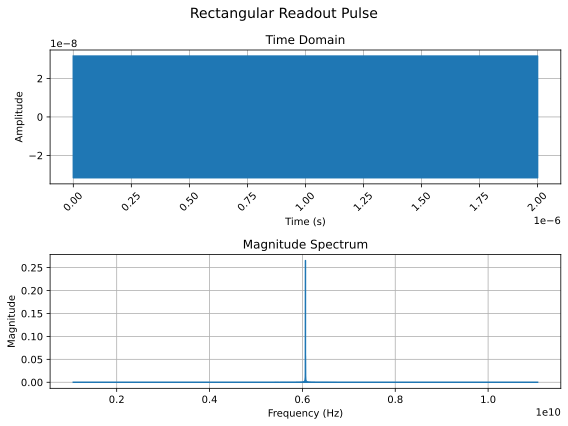

In [26]:
f_pulse = fr0_meas * 10 ** 9 # Hz

pulse_length = 2 * 10 ** (-6) # s
total_signal_time = 2 * 10 ** (-6) # s

pulse_samples_number = 2 ** 23
rect_readout_pulse = RectangularReadoutPulse(
    carrier_frequency=f_pulse,
    pulse_duration=pulse_length,
    pulse_power_dbm=-140,
    total_signal_time=total_signal_time,
    pulse_samples_number=pulse_samples_number,
)

rect_readout_pulse.plot_pulse()

In [27]:
delta_arr = -1 * np.linspace(1, 5, 100)

In [28]:
# f01_meas - if TEMPLATE_FILE = "template_0ghz_resonator_cut_wide.s2p"
# 0 - if TEMPLATE_FILE = "data_00000_0_ghz.s2p"
original_peak_frequency = 0

shift_s2p_freq_axis_minimal(template_file_path, os.path.join(simulation_path, "original.s2p"), original_peak_frequency)

fidelity = []
for delta in (pbar := tqdm(delta_arr)):
    chi = -g_fitted ** 2 / delta * (1 / (1 + delta / alpha))

    file_state_0 = os.path.join(simulation_path, f"{delta}_0.s2p")
    file_state_1 = os.path.join(simulation_path, f"{delta}_1.s2p")
    shift_s2p_freq_axis_minimal(template_file_path, file_state_0, original_peak_frequency + chi)
    shift_s2p_freq_axis_minimal(template_file_path, file_state_1, original_peak_frequency - chi)


    fidelity_simulation = FidelitySimulation(
        s_parameters_file_state_0=file_state_0,
        s_parameters_file_state_1=file_state_1,
        readout_pulse=rect_readout_pulse,
        IQ_projection_frequency=rect_readout_pulse.carrier_frequency + 200e6,  # f_fi = 200MHz
        num_iterations=250,
        readout_dt=1e-9,
        plot_pulses=False,
        plot_result=False,
        disable_progress_bar=True,
    )

    result = fidelity_simulation.run()
    fidelity.append(result)
    pbar.set_postfix_str(f"fidelity = {result}")



100%|██████████| 100/100 [2:32:02<00:00, 91.23s/it, fidelity = 0.86]  ges/joblib/externals/loky/process_executor.py: 782


In [29]:
fidelity

[0.978,
 0.974,
 0.99,
 0.982,
 0.984,
 0.99,
 0.976,
 0.972,
 0.978,
 0.986,
 0.964,
 0.962,
 0.968,
 0.952,
 0.956,
 0.954,
 0.956,
 0.956,
 0.964,
 0.97,
 0.96,
 0.956,
 0.95,
 0.966,
 0.958,
 0.954,
 0.974,
 0.958,
 0.948,
 0.946,
 0.978,
 0.972,
 0.97,
 0.972,
 0.968,
 0.978,
 0.966,
 0.978,
 0.974,
 0.976,
 0.964,
 0.964,
 0.974,
 0.968,
 0.974,
 0.968,
 0.982,
 0.978,
 0.968,
 0.97,
 0.964,
 0.97,
 0.976,
 0.958,
 0.946,
 0.968,
 0.938,
 0.954,
 0.956,
 0.938,
 0.958,
 0.95,
 0.954,
 0.924,
 0.934,
 0.952,
 0.93,
 0.936,
 0.926,
 0.946,
 0.93,
 0.902,
 0.93,
 0.908,
 0.92,
 0.896,
 0.896,
 0.91,
 0.91,
 0.892,
 0.876,
 0.902,
 0.9,
 0.906,
 0.892,
 0.884,
 0.85,
 0.864,
 0.856,
 0.874,
 0.842,
 0.858,
 0.842,
 0.832,
 0.872,
 0.858,
 0.81,
 0.828,
 0.834,
 0.86]

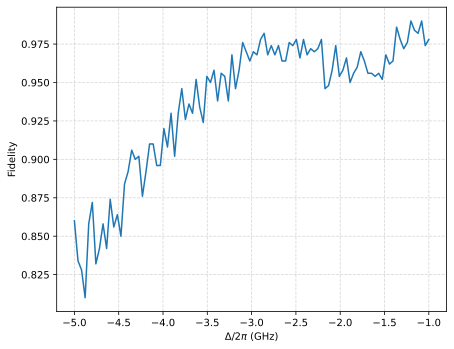

In [30]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5.5), sharex=True, dpi=300)

axs.set_xlabel(r'$\Delta/2\pi$ (GHz)')
axs.set_ylabel('Fidelity')
axs.grid(True, linestyle='--', alpha=0.5)
# axs.set_yscale("log")

axs.plot(delta_arr, fidelity)

plt.savefig("detuning_fidelity_4.png")
plt.show()

In [31]:
import skrf as rf
import matplotlib.pyplot as plt
import numpy as np
import os

fig, ax_s21 = plt.subplots(1, 1, figsize=(8, 7), dpi=300)

cmap = plt.cm.get_cmap('viridis', len(delta_arr))


def plot_file(filepath, iteration_n, states):
    network = rf.Network(filepath)

    frequencies_ghz = network.f
    label = None
    color = cmap(iteration_n)

    if iteration_n == 0 or iteration_n == len(delta_arr) - 1:
        label = rf"S21, State |{states}>" + r"$\text{ with } \Delta/2\pi=$" + str(delta_arr[i]) + "GHz"

    s21_complex = network.s[:, 1, 0]
    ax_s21.plot(frequencies_ghz, np.abs(s21_complex), color=color, label=label)

for i, delta in tqdm(enumerate(delta_arr), total=len(delta_arr)):
    path = os.path.join(simulation_path, f"{delta}_0.s2p")
    plot_file(path, i, 0)
    path = os.path.join(simulation_path, f"{delta}_1.s2p")
    plot_file(path, i, 1)

readout_pulse = RectangularReadoutPulse(
    carrier_frequency=fr0_meas * 10 ** 9,
    pulse_duration=2 * 10 ** (-6),
    pulse_power_dbm=-140,
    total_signal_time=2 * 10 ** (-6),
    pulse_samples_number=2 ** 23,
)

ax_s21.plot(readout_pulse.f_signal_frequencies, readout_pulse.f_signal, c='r', label="Rect Readout pulse", linewidth=3)

ax_s21.set_xlabel('Frequency (Hz)')

ax_s21.set_xlim(fr0_meas*1e9*0.999, fr0_meas*1e9*1.001)

ax_s21.grid(True, linestyle='--', alpha=0.5)

ax_s21.legend(loc='lower left')
plt.title(f"S21 and readout pulse, g={g_fitted} GHz")
plt.tight_layout()

plt.savefig("s_params.png")

plt.show()

100%|██████████| 100/100 [00:00<00:00, 147.71it/s]ipykernel_2284/1785238016.py: 8
 /Users/user/PycharmProjects/wmiklayout/venv/lib/python3.12/site-packages/matplotlib/cbook.py: 1719ComplexWarning: Casting complex values to real discards the imaginary part
 /Users/user/PycharmProjects/wmiklayout/venv/lib/python3.12/site-packages/matplotlib/cbook.py: 1355